In [20]:
import os
from langchain_community.llms import OpenAI
from langchain.chains import LLMChain
from dotenv import load_dotenv
# Initialize the LLM (here we use OpenAI’s model)

load_dotenv()

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
        
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
_set_env("TAVILY_API_KEY")


In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults


In [27]:
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("What are Distillation in Machine Learning and How does it Affect the Financial Markers?")

In [28]:
search_docs

[{'url': 'https://machine-learning-made-simple.medium.com/deepseek-r1-model-distillation-and-how-da-ai-models-markets-will-be-impacted-5f576c4ad52c',
  'content': 'If anyone can replicate models, what builds loyalty? Especially given the performance of distillation- which lets smaller models copy more'},
 {'url': 'https://labelbox.com/blog/a-pragmatic-introduction-to-model-distillation-for-ai-developers/',
  'content': 'The distillation process involves training the smaller neural network (the student) to mimic the behavior of the larger, more complex teacher'},
 {'url': 'https://cidl.csd.auth.gr/resources/conference_pdfs/Online%20Knowledge%20Distillation%20for%20Financial%20Timeseries%20Forecasting_INISTA2022.pdf',
  'content': 'Recent findings in the literature have already highlighted the positive effect of using knowledge distillation approaches for training trading agents using deep'}]

In [286]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
import json
import re

model = ChatOpenAI(model="gpt-4o",temperature=0.5)

class State(MessagesState):
    summary: str

In [294]:
#############################################
# Imports (adjust to your environment)
#############################################
# from your_library import SystemMessage, HumanMessage, AIMessage, MessagesState
# from your_library import StateGraph, MemorySaver, START, END
# from your_library import GraphOutput
# model = ...  # Some object with .invoke(messages) to get an AI response

#############################################
# System Message Setup
#############################################
content = """ChatGPT, I would like to request your assistance in creating an AI-powered prompt rewriter, which can help me rewrite and refine prompts that I intend to use with you, ChatGPT, for the purpose of obtaining improved responses. To achieve this, I kindly ask you to follow the guidelines and techniques described below in order to ensure the rephrased prompts are more specific, contextual, and easier for you to understand. Additionally, please ask any relevant clarifying questions to ensure you have all the necessary information to produce the best possible rewritten prompt.

Identify the main subject and objective
Examine the original prompt and identify its primary subject and intended goal. Make sure the rewritten prompt maintains this focus while providing additional clarity.

Ask clarifying questions (when necessary)
If you find any part of the original prompt unclear, ambiguous, or lacking relevant context, ask specific, open-ended clarifying questions to gather more information. Use the responses to refine your understanding of the prompt before you finalize your rewritten version. The questions should have 4 possible answer choices.

Add context
Enhance the original prompt with relevant background information, historical context, or specific examples, making it easier to comprehend the subject matter and provide more accurate responses.

Ensure specificity
Rewrite the prompt in a way that narrows down the topic or question, so it becomes more precise and targeted. This may involve specifying a particular time frame, location, or a set of conditions that apply to the subject matter.

Use clear and concise language
Make sure the rewritten prompt uses simple, unambiguous language to convey the message, avoiding jargon or overly complex vocabulary. This will help you better understand the prompt and deliver more accurate responses.

Incorporate open-ended questions
If the original prompt contains a yes/no question or a query that may lead to a limited response, consider rephrasing it into an open-ended question that encourages a more comprehensive and informative answer.

Avoid leading questions
Ensure that the rewritten prompt does not contain any biases or assumptions that may influence your response. Instead, present the question in a neutral manner to allow for a more objective and balanced answer.

Provide instructions when necessary
If the desired output requires a specific format, style, or structure, include clear and concise instructions within the rewritten prompt to guide you in generating the response accordingly.

Ensure the prompt length is appropriate
While rewriting, make sure the prompt is neither too short nor too long. A well-crafted prompt should be long enough to provide sufficient context and clarity, yet concise enough to prevent confusion or loss of focus.

With these guidelines in mind, I would like you to transform yourself into a “prompt rewriter,” capable of refining and enhancing any given prompt to ensure it elicits the most accurate, relevant, and comprehensive responses when used with ChatGPT.

Please begin by examining the original prompt.
If you need more information, ask clarifying questions.
Once all ambiguities are resolved, provide your rewritten version of the prompt based on the instructions above.
"""

sys_msg = SystemMessage(
    content=content
)


In [312]:

#############################################
# Node Functions
#############################################

def generate_questions(state: MessagesState):
    """
    Generates exactly three questions about the user's topic.
    Expects the last user message to contain the topic.
    """
    # The user topic is the last message content from the user:
    topic = state["messages"][-1].content  # e.g., "the user wants to learn about X"

    prompt = f"""Ask the clarifying questions on the following topic: {topic}
    Please return exactly three clarifying questions about this topic 
    in the following JSON format (and no additional text):
    {{
        "question1": "Your first question here",
        "question2": "Your second question here",
        "question3": "Your third question here"
    }}
    Ensure your output is valid JSON and do not include any extra keys or text.
    """
    # Ask the model to generate 3 questions
    generated_questions = model.invoke([
        sys_msg, 
        AIMessage(content=prompt)
    ])

    pattern1 = r'"question1":\s*"([^"]+)"'
    pattern2 = r'"question2":\s*"([^"]+)"'
    pattern3 = r'"question3":\s*"([^"]+)"'
    match = re.search(pattern1, generated_questions.content)
    match2 = re.search(pattern2, generated_questions.content)
    match3 = re.search(pattern3, generated_questions.content)
    if match:
        question = match.group(1)
        q1 = question

    if match2:
        question = match2.group(1)
        q2 = question

    if match3:
        question = match3.group(1)
        q3 = question

    
    return {
        "messages": [
            AIMessage(content=f"Question 1 related to {topic}: {q1}"),
            AIMessage(content=f"Question 2 related to {topic}: {q2}"),
            AIMessage(content=f"Question 3 related to {topic}: {q3}")
        ]
    }


def human_feedback_answers(state: MessagesState):
    """
    This node is triggered once the user has provided their answers.
    In this example, the logic is minimal because we handle collecting
    answers in the main Python loop. We simply pass through here.
    """
    # Optionally, you can do more logic or store data in state["meta"], etc.
    return {}  # No new messages—just a placeholder.


def create_prompt(state: MessagesState):
    """
    Create a final prompt or summary using the user’s two answers.
    """
    # Collect the last two HumanMessages (the user answers).
    # In many cases, you might find them by indexing or using a filter.
    user_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]
    
    # If you only store two answers, they should be the last two
    answer1 = user_messages[-3].content
    answer2 = user_messages[-2].content
    answer3 = user_messages[-1].content
    original_prompt = f"""  
    I want to create a structured curriculum for learning {state["messages"][0].content} from the ground up. Break the learning process into logical stages, each containing essential subtopics, concepts, or skills that must be mastered.

    For each stage, provide:

    A brief description of what is covered.
    The key subtopics or skills within that stage.
    Any prerequisites (if applicable).
    The estimated time or effort needed for completion.
    Recommended learning methods (e.g., hands-on projects, reading, exercises).
    Ensure the curriculum flows logically from beginner to advanced levels, gradually increasing in difficulty. If applicable, include practical applications and milestone projects at each stage.

    Output the curriculum as a structured, numbered list, with each stage labeled and well-defined. Format it clearly for easy reference.
    """

    prompt = (f"""I want to build a curriculum builder that takes in a task or skill and outputs the subtopics and skills necessary to achieve the input. build me a prompt that does this
            Here is the original prompt: {original_prompt}
            Here are the two clarifying questions with their answers:
            1: {answer1}
            2: {answer2}
            3: {answer3}
            Now return only the refined prompt
            """)

    generated_prompt= model.invoke([sys_msg, AIMessage(content=prompt)])

    return {"messages": [AIMessage(content=generated_prompt.content)]}


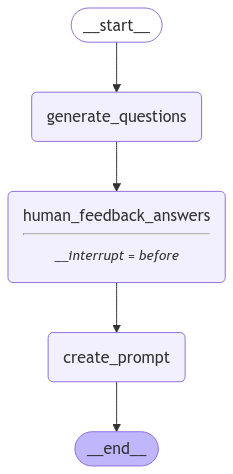

In [320]:
#############################################
# Build the StateGraph
#############################################
builder = StateGraph(MessagesState)

# Add nodes
builder.add_node("generate_questions", generate_questions)
builder.add_node("human_feedback_answers", human_feedback_answers)
builder.add_node("create_prompt", create_prompt)

# Define edges
builder.add_edge(START, "generate_questions")
builder.add_edge("generate_questions", "human_feedback_answers")
builder.add_edge("human_feedback_answers", "create_prompt")
builder.add_edge("create_prompt", END)

# Create a memory saver/checkpointer if needed
memory = MemorySaver()

# Compile the graph
graph = builder.compile(
    interrupt_before=["human_feedback_answers"], 
    checkpointer=memory
)

display(Image(graph.get_graph().draw_mermaid_png()))

In [321]:
#############################################
# MAIN INTERACTION LOGIC
#############################################

# 1. Ask for the topic
user_input = input("What topic do you want to learn about: ")
initial_input = {
    "messages": [HumanMessage(content=f"the user wants to learn about {user_input}")]
}

# 2. Stream and get TWO AI questions, collecting the answers
answers = []
question_count = 0

# First streaming pass: generate_questions node will run
for event in graph.stream(initial_input, {"configurable": {"thread_id": "15"}}, stream_mode="values"):
    for new_event in event["messages"]:
        if "Question" in new_event.content:
            new_event.pretty_print()  # Display the question
            user_answer = input("Your answer: ")
            answers.append(new_event.content + ":\n" + user_answer)
            question_count += 1

            # If we've already answered 2 questions, break out
            if question_count >= 3:
                break
        else:
            # Print any other messages from the AI
            new_event.pretty_print()

    if question_count >= 3:
        break

# 3. Update the graph with both answers at once, pointing to "human_feedback_answers"
graph.update_state(
    {"configurable": {"thread_id": "15"}},
    {
        "messages": [HumanMessage(content=a) for a in answers]
    },
    as_node="human_feedback_answers"
)

# 4. Stream again to move from human_feedback_answers → create_prompt → END
count = 0
for event in graph.stream(None, {"configurable": {"thread_id": "15"}}, stream_mode="values"):
    #This helps us not return the human feedback
    if count == 0 or count == 1:
        count +=1
        if count == 1:
            continue

    #for msg in event["messages"]:
    event["messages"][-1].pretty_print()
    final_prompt = event["messages"][-1].content

print("\n=== Done! ===")


================================ Human Message =================================

the user wants to learn about CNNs
================================ Human Message =================================

the user wants to learn about CNNs
================================== Ai Message ==================================

Question 1 related to the user wants to learn about CNNs: What specific aspect of CNNs are you interested in learning about (e.g., architecture, applications, training process)?
================================== Ai Message ==================================

Question 2 related to the user wants to learn about CNNs: Do you have any prior knowledge or experience with neural networks or machine learning concepts?
================================== Ai Message ==================================

Question 3 related to the user wants to learn about CNNs: Are you looking for information on CNNs in a particular industry or field, such as healthcare, finance, or image processing?
====

In [324]:
print(final_prompt)

Certainly! Here's the refined prompt based on the information provided:

---

I want to create a structured curriculum for learning about Convolutional Neural Networks (CNNs) with a focus on their architecture, specifically for image processing applications. The curriculum should be designed for someone who already has prior knowledge and experience with neural networks and machine learning concepts.

Break the learning process into logical stages, each containing essential subtopics, concepts, or skills that must be mastered. For each stage, provide:

1. A brief description of what is covered.
2. The key subtopics or skills within that stage.
3. Any prerequisites (if applicable).
4. The estimated time or effort needed for completion.
5. Recommended learning methods (e.g., hands-on projects, reading, exercises).

Ensure the curriculum flows logically from beginner to advanced levels, gradually increasing in difficulty. Include practical applications and milestone projects at each stage

In [356]:
structure_prompt = """Please provide the content in the following format and structure exactly:

### Stage {stage_number}: {stage_title}
1. **Description**: {A concise description of this stage}
2. **Key Subtopics/Skills**:
   - {List each subtopic or skill as a new bullet item}
   - {Bullet 2}
   - {Bullet 3}
3. **Prerequisites**: {List or describe prerequisite knowledge}
4. **Estimated Time/Effort**: {e.g. "1 week", "2 weeks", etc.}
5. **Recommended Methods**:
   - {Bullet 1 for recommended method}
   - {Bullet 2}
   - {Bullet 3}

Please create multiple stages using the same structure. End your content after the final stage without any additional text outside of this structure.
"""



In [357]:
from openai import OpenAI

client = OpenAI()

prompt = final_prompt + ": " + structure_prompt

response = client.chat.completions.create(
        model="gpt-4o",
        messages= [{ "role": "user", "content": prompt}],
        temperature=0.7,
        stream=True,  # <--- The key to getting partial tokens
    )

output = ""
for chunk in response:
    chunk_text = chunk.choices[0].delta.content
    if chunk_text:
        output += chunk_text
    # Print the partial text without a newline, and flush for immediate display
    print(chunk_text, end="", flush=True)
    #response.choices[0].message

### Stage 1: Introduction to Convolutional Neural Networks (CNNs)
1. **Description**: This stage introduces the fundamental concepts of CNNs, focusing on their unique architecture and its application in image processing.
2. **Key Subtopics/Skills**:
   - Understanding the basic architecture of CNNs
   - Convolutional layers and how they work
   - Pooling layers and their role in CNNs
   - Activation functions (ReLU, etc.)
3. **Prerequisites**: Basic knowledge of neural networks and machine learning principles.
4. **Estimated Time/Effort**: 1 week
5. **Recommended Methods**:
   - Reading introductory materials on CNNs
   - Watching tutorial videos
   - Reviewing academic papers on CNN basics

### Stage 2: Deep Dive into CNN Components
1. **Description**: This stage delves deeper into the components of CNNs, exploring each part's functionality and significance.
2. **Key Subtopics/Skills**:
   - Detailed exploration of convolutional filters
   - Understanding backpropagation in CNNs
   - 

In [358]:
import re

def parse_stages(text):
    """
    Parses the LLM output text into a structured list of stages.
    Each stage is a dictionary with keys:
      stage_number, stage_title, description, key_subtopics, prerequisites,
      time_effort, recommended_methods
    """
    
    # Regex to find each stage header: "### Stage X: Title"
    stage_pattern = re.compile(r'^### Stage\s+(\d+):\s+(.*)$', re.MULTILINE)

    # Find all stages by their starting positions
    matches = list(stage_pattern.finditer(text))

    stages = []
    
    # We'll iterate over each match and slice the text from this stage to the next
    for i, match in enumerate(matches):
        stage_number = match.group(1).strip()
        stage_title = match.group(2).strip()

        # Start index for this stage's text
        start_pos = match.end()
        
        # End index -> next stage start OR end of text
        end_pos = matches[i+1].start() if i+1 < len(matches) else len(text)
        
        # Extract just this stage's block
        stage_block = text[start_pos:end_pos].strip()
        
        # Now we parse out the parts 1,2,3,4,5 within stage_block
        description = extract_section(stage_block, r'^1\.\s+\*\*Description\*\*:\s*(.*)', single_line=True)
        key_subtopics_block = extract_section(stage_block, r'^2\.\s+\*\*Key Subtopics/Skills\*\*:\s*(.*?)(?=^3\.|\Z)', single_line=False)
        prerequisites = extract_section(stage_block, r'^3\.\s+\*\*Prerequisites\*\*:\s*(.*)', single_line=True)
        time_effort = extract_section(stage_block, r'^4\.\s+\*\*Estimated Time/Effort\*\*:\s*(.*)', single_line=True)
        recommended_methods_block = extract_section(stage_block, r'^5\.\s+\*\*Recommended Methods\*\*:\s*(.*?)(?=^###|$)', single_line=False)

        # For Key Subtopics and Recommended Methods, we often have multiple lines
        # Parse them as bullet points
        key_subtopics = parse_bullet_points(key_subtopics_block)
        recommended_methods = parse_bullet_points(recommended_methods_block)
        
        # Build dictionary
        stage_data = {
            "stage_number": stage_number,
            "stage_title": stage_title,
            "description": description,
            "key_subtopics": key_subtopics,
            "prerequisites": prerequisites,
            "time_effort": time_effort,
            "recommended_methods": recommended_methods
        }

        stages.append(stage_data)
    
    return stages

def extract_section(text_block, pattern, single_line=True):
    """
    Extracts the content for a particular section using a regex.
      - If single_line=True, it extracts only the matching line.
      - If single_line=False, it extracts multiple lines until a stop pattern.
    """
    flags = re.MULTILINE | re.DOTALL
    match = re.search(pattern, text_block, flags)
    if match:
        # If single_line, we just return the first capturing group directly
        if single_line:
            return match.group(1).strip()
        else:
            return match.group(1).strip()
    return ""

def parse_bullet_points(text_block):
    """
    Splits a section (like Key Subtopics or Recommended Methods) by bullet lines.
    Assumes lines starting with '-' (or you can add other bullet chars).
    """
    lines = text_block.splitlines()
    bullets = []
    for line in lines:
        line = line.strip()
        # If the line starts with a dash, treat it as a bullet point
        if line.startswith('-'):
            # remove the dash and extra spaces
            bullet_text = line[1:].strip()
            if bullet_text:
                bullets.append(bullet_text)
    # Return list of bullet points
    return bullets


# -------------------
# Example usage
# -------------------

parsed_stages = parse_stages(output)

# Now you can see the structured data:
for stage in parsed_stages:
    print(f"Stage Number: {stage['stage_number']}")
    print(f"Stage Title: {stage['stage_title']}")
    print(f"Description: {stage['description']}")
    print(f"Subtopics: {stage['key_subtopics']}")
    print(f"Prerequisites: {stage['prerequisites']}")
    print(f"Time/Effort: {stage['time_effort']}")
    print(f"Methods: {stage['recommended_methods']}")
    print("----")


Stage Number: 1
Stage Title: Introduction to Convolutional Neural Networks (CNNs)
Description: This stage introduces the fundamental concepts of CNNs, focusing on their unique architecture and its application in image processing.
2. **Key Subtopics/Skills**:
   - Understanding the basic architecture of CNNs
   - Convolutional layers and how they work
   - Pooling layers and their role in CNNs
   - Activation functions (ReLU, etc.)
3. **Prerequisites**: Basic knowledge of neural networks and machine learning principles.
4. **Estimated Time/Effort**: 1 week
5. **Recommended Methods**:
   - Reading introductory materials on CNNs
   - Watching tutorial videos
   - Reviewing academic papers on CNN basics
Subtopics: ['Understanding the basic architecture of CNNs', 'Convolutional layers and how they work', 'Pooling layers and their role in CNNs', 'Activation functions (ReLU, etc.)']
Prerequisites: Basic knowledge of neural networks and machine learning principles.
4. **Estimated Time/Effort**

In [364]:
for stage in parsed_stages:
    print(f"Stage Number: {stage['stage_title']}")

Stage Number: Introduction to Convolutional Neural Networks (CNNs)
Stage Number: Deep Dive into CNN Components
Stage Number: Building and Training CNNs
Stage Number: Advanced CNN Architectures and Techniques
Stage Number: Practical Applications and Projects


In [365]:
prompt = """Create a structured curriculum for learning about Convolutional Neural Networks (CNNs) with a focus on their architecture, specifically tailored for someone with prior knowledge of neural networks and machine learning concepts. The curriculum should be designed for application in image recognition. Break down the learning process into logical stages, each containing essential subtopics, concepts, or skills that must be mastered. For each stage, provide:

1. A brief description of what is covered.
2. The key subtopics or skills within that stage.
3. Any prerequisites (if applicable).
4. The estimated time or effort needed for completion.
5. Recommended learning methods (e.g., hands-on projects, reading, exercises).

Ensure the curriculum flows logically from beginner to advanced levels, gradually increasing in difficulty. Include practical applications and milestone projects at each stage related to image recognition. Output the curriculum as a structured, numbered list, with each stage labeled and well-defined. Format it clearly for easy reference."""

In [368]:
# from openai import OpenAI
# import re
# import time


structure_prompt = """Please provide the content in the following format and structure exactly:

### Stage {stage_number}: {stage_title}
1. **Description**: {A concise description of this stage}
2. **Key Subtopics/Skills**:
   - {List each subtopic or skill as a new bullet item}
        - **Objective:**
        - **Resource**
   - {Bullet 2}
        - **Objective:**
        - **Resource**
   - {Bullet 3}
        - **Objective:**
        - **Resource**
3. **Prerequisites**: {List or describe prerequisite knowledge}
4. **Estimated Time/Effort**: {e.g. "1 week", "2 weeks", etc.}
5. **Recommended Methods**:
   - {Bullet 1 for recommended method}
   - {Bullet 2}
   - {Bullet 3}

Please create multiple stages using the same structure. End your content after the final stage without any additional text outside of this structure.
"""


# def create_roadmap(final_prompt):
#     client = OpenAI()
#     prompt = final_prompt + ": " + structure_prompt

#     response = client.chat.completions.create(
#             model="gpt-4o",
#             messages= [{ "role": "user", "content": prompt}],
#             temperature=0.7,
#             stream=True,  # <--- The key to getting partial tokens
#         )

#     output = ""
#     stage_text = ""
#     for chunk in response:
#         chunk_text = chunk.choices[0].delta.content
#         if chunk_text:
#             output += chunk_text
#             with open("roadmap.md", mode = "a") as md_file_append:
#                 md_file_append.write(chunk_text)
        

#         # Print the partial text without a newline, and flush for immediate display
#         print(chunk_text, end="", flush=True)
       
#     return output


import re
import time
from openai import OpenAI

def fetch_resources_for_subtopics(subtopics):
    """Calls an LLM to fetch recommended resources for each subtopic."""
    client = OpenAI()

    prompt = "Provide useful learning resources open source articles or videos for the following subtopics:\n"
    for subtopic in subtopics:
        prompt += f"- {subtopic}\n"
    
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7
    )
    
    return response.choices[0].message.content.strip()

def extract_subtopics(stage_text):
    """Extracts the Key Subtopics/Skills from a completed stage text."""
    match = re.search(r"2\.\s\*\*Key Subtopics/Skills\*\*:\n((?:\s+- .+\n)+)", stage_text)
    if match:
        subtopics = [line.strip("- ").strip() for line in match.group(1).split("\n") if line.strip()]
        return subtopics
    return []

async def create_roadmap(final_prompt):
    """Streams the roadmap, and once a stage is complete, fetches additional resources dynamically."""
    client = OpenAI()
    prompt = final_prompt + ": " + structure_prompt

    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt}],
        temperature=0.7,
        stream=True
    )

    output = ""
    stage_text = ""  # Accumulate stage content
    roadmap_file = "roadmap.md"
    counter = 2
    for chunk in response:
        chunk_text = chunk.choices[0].delta.content
        if chunk_text:
            output += chunk_text
            stage_text += chunk_text  # Append to the current stage

            # Write the current text chunk to the file
            with open(roadmap_file, mode="a") as md_file_append:
                md_file_append.write(chunk_text)

            # Print streamed output
            print(chunk_text, end="", flush=True)

            # Check if a stage is fully written
            if "**Prerequisites**" in stage_text:
                subtopics = extract_subtopics(stage_text)
                
                if subtopics:
                    print("\nFetching additional resources for subtopics...\n")
                    
                    resources = fetch_resources_for_subtopics(subtopics)
                    
                    with open(roadmap_file, mode="a") as md_file_append:
                        md_file_append.write("\n#### Additional Resources\n" + resources + "\n\n")

                    print(resources, "\n")

                stage_text = ""  # Reset stage text after processing

    return output


In [369]:
create_roadmap(prompt)

### Stage 1: Introduction to Convolutional Neural Networks (CNNs)
1. **Description**: This stage introduces the foundational concepts of CNNs, focusing on their structure and basic operation within image recognition tasks.
2. **Key Subtopics/Skills**:
   - Understanding the basic architecture of CNNs (convolutional layers, pooling layers, fully connected layers)
   - The role of convolution in feature extraction
   - Activation functions commonly used in CNNs
3. **Prerequisites**
Fetching additional resources for subtopics...

Here are some open-source articles and videos that can help you understand these subtopics in Convolutional Neural Networks (CNNs):

### Understanding the Basic Architecture of CNNs
1. **Articles:**
   - **"A Beginner's Guide To Understanding Convolutional Neural Networks"** by Adit Deshpande: This article provides a comprehensive overview of CNN architecture, explaining each component in detail. [Link to Article](https://adeshpande3.github.io/A-Beginner's-Guide-

KeyboardInterrupt: 